In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
from tqdm import tqdm


import PIL

import matplotlib.pyplot as plt


In [33]:
import open_clip
from open_clip import tokenizer
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion400m_e32')

In [34]:
data_format = ".png"
if data_format == ".npy":
    data = np.load('/cluster/scratch/nkoisheke/gen_images.npy')
else:
    data = []
    path = "/cluster/scratch/nkoisheke/1_5/"
    number_of_images = 249 * 15
    for i in range(number_of_images):
        img = PIL.Image.open(path + str(i) + ".png")
        data.append(img)
        
    

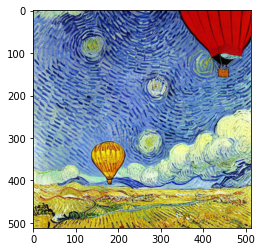

In [35]:
%matplotlib inline

temp_image = data[0]

plt.imshow(temp_image)

# Check on generated images

## Get image features

In [36]:
image_features = []
batch_size = 64

with torch.no_grad():
    for i in tqdm(range(0, len(data), batch_size)):
        batch = []
        for j in range(i, min(i+batch_size, len(data))):
            if data_format == ".npy":
                img = PIL.Image.fromarray(data[j])
            else:
                img = data[j]
            img = preprocess(img)
            batch.append(img)
    
        batch = torch.tensor(np.stack(batch))
        img_feats = model.encode_image(batch).float()
        image_features.append(img_feats)
image_features_torch = torch.concatenate(image_features)

100%|██████████| 59/59 [08:33<00:00,  8.70s/it]


 Clean the data

In [37]:
del data

## Get text features

In [38]:
# read csv file
import pandas as pd
df = pd.read_csv('/cluster/scratch/nkoisheke/gen_images_1_5.csv')
df.head()

print(df.shape)

(3735, 5)


In [39]:
artists = df['artist'].unique()
text_features = []

with torch.no_grad():
    for artist in artists:
        prompt = "The following work is done in the style of " + artist
        text_tokens = tokenizer.tokenize(prompt)
        txt_feat = model.encode_text(text_tokens).float()
        text_features.append(txt_feat)
text_features_torch = torch.concatenate(text_features)

In [40]:
idx2artist = {}
artist2idx = {}
for i, artist in enumerate(artists):
    idx2artist[i] = artist
    artist2idx[artist] = i

## Compute cosine similarity

In [41]:
image_features_torch /= image_features_torch.norm(dim=-1, keepdim=True)
text_features_torch /= text_features_torch.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features_torch @ text_features_torch.T).softmax(dim=-1)
top_probs, top_k_labels = text_probs.cpu().topk(5, dim=-1)

In [42]:
gt_labels = torch.tensor([artist2idx[x] for x in df['artist'].to_list()])

top_one_labels = top_k_labels[:, 0]

print(gt_labels.shape, top_one_labels.shape)

correct = (gt_labels == top_one_labels).sum()
print(f"Top 1 score is {round((correct / gt_labels.shape[0]).item() * 100, 2)}")


topk_correct = 0
for i in range(5):
    top_one_labels = top_k_labels[:, i]
    correct = (gt_labels == top_one_labels).sum()
    topk_correct += correct
print(f"Top 5 score is {round((topk_correct / gt_labels.shape[0]).item() * 100, 2)}")
# correct = (gt_labels.repeat() == top_k_labels).sum()
# print(correct)

torch.Size([3735]) torch.Size([3735])
Top 1 score is 8.81
Top 5 score is 22.78


# Check on real images

In [20]:
import os
path = "/cluster/scratch/nkoisheke/artworks_images/"
df = pd.read_csv('../Scraping/googleart/Data/googleart_art_data_final.csv', sep='\t')

In [21]:
df.head()

,artist_name,artwork_title,artwork_date,artwork_url,image_url,image_path
0,Vincent van Gogh,Self-Portrait,1889,https://artsandculture.google.com/asset/self-p...,blob:https://artsandculture.google.com/46b00d1...,./Scraping/googleart/Data/artworks_images/imag...
1,Vincent van Gogh,The Starry Night,1889,https://artsandculture.google.com/asset/the-st...,blob:https://artsandculture.google.com/30b15a6...,./Scraping/googleart/Data/artworks_images/imag...
2,Vincent van Gogh,Almond Blossom,February 1890 - 1890,https://artsandculture.google.com/asset/almond...,blob:https://artsandculture.google.com/78cc161...,./Scraping/googleart/Data/artworks_images/imag...
3,Vincent van Gogh,Country road in Provence by night,c. 12 - 15 May 1890,https://artsandculture.google.com/asset/countr...,blob:https://artsandculture.google.com/4873671...,./Scraping/googleart/Data/artworks_images/imag...
4,Vincent van Gogh,Starry Night,1888,https://artsandculture.google.com/asset/starry...,blob:https://artsandculture.google.com/fe464bc...,./Scraping/googleart/Data/artworks_images/imag...


In [22]:
image_paths = [path + img.split('/')[-1] for img in df["image_path"].to_list()]

## Get image features

In [ ]:
image_features = []
batch_size = 64

with torch.no_grad():
    for i in tqdm(range(0, len(image_paths), batch_size)):
        batch = []
        for j in range(i, min(i+batch_size, len(image_paths))):
            img = PIL.Image.open(image_paths[j])
            img = preprocess(img)
            batch.append(img)
        batch = torch.tensor(np.stack(batch))
        img_feats = model.encode_image(batch).float()
        image_features.append(img_feats)
image_features_torch = torch.concatenate(image_features)

In [ ]:
artists = df['artist_name'].unique()
text_features = []

with torch.no_grad():
    for artist in artists:
        prompt = "The following work is done in the style of " + artist
        text_tokens = tokenizer.tokenize(prompt)
        txt_feat = model.encode_text(text_tokens).float()
        text_features.append(txt_feat)
text_features_torch = torch.concatenate(text_features)

## Compute probabilities

In [ ]:
image_features_torch /= image_features_torch.norm(dim=-1, keepdim=True)
text_features_torch /= text_features_torch.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features_torch @ text_features_torch.T).softmax(dim=-1)
top_probs, top_k_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
gt_labels = torch.tensor([artist2idx[x] for x in df['artist_name'].to_list()])

top_one_labels = top_k_labels[:, 0]

print(gt_labels.shape, top_one_labels.shape)

correct = (gt_labels == top_one_labels).sum()
print(f"Top 1 score is {round((correct / gt_labels.shape[0]).item() * 100, 2)}")


topk_correct = 0
for i in range(5):
    top_one_labels = top_k_labels[:, i]
    correct = (gt_labels == top_one_labels).sum()
    topk_correct += correct
print(f"Top 5 score is {round((topk_correct / gt_labels.shape[0]).item() * 100, 2)}")
# correct = (gt_labels.repeat() == top_k_labels).sum()
# print(correct)